# Exploring ACIS / PRISM weather data and GDU curves

In this notebook we will download ACIS / PRISM gridded weather data and use it to compute GDU curves at a specific field. It is the start of a data processing scheme that brings insight into field state and operational planning.

Let us begin by importing some useful libraries that will be used throughout the notebook. Those are:
1. requests: Makes HTTP requests. We will use it to grab data from ACIS.
2. pandas: A popular tool for doing data analysis in python. We will use it for just about everything :).
3. matplotlib: A tool for making graphical plots. We will use it to, well, make plots!

_Note:_ I set the matplotlib style to “seaborn” because I like it better. It is not required and your welcome to adjust it to your liking.

In [42]:
import requests
import pandas as pd
import matplotlib.pyplot as plt # This is just so we don't have to type "matplotlib.pyplot" all the time.

In [43]:
# Setup some plotting styles 
#%matplotlib notebook
%matplotlib inline
plt.style.use('seaborn')

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20, figsize=(15, 8))  # fontsize of the figure title

Let us start by grabbing some ACIS weather data for a field at Purdue's [ACRE farm](https://www.google.com/maps/place/40%C2%B028'27.2%22N+86%C2%B059'43.7%22W/@40.4742259,-86.9975974,1242m/data=!3m1!1e3!4m5!3m4!1s0x0:0x0!8m2!3d40.4742222!4d-86.9954722). That is GPS coordinate: (40.4742259,-86.9975974).

We will grab all the _historical_ data that ACIS/PRISM has available. Let's ignore _this_ years data for now (because it is incomplete).

It is okay if you don't understand all this code right now. We will spend some time getting used to Python/Pandas before we compute the GDU curves.

In [44]:
# GPS coordinates of interest
lat = 40.4742259
lon = -86.9975974

# PRISM usally goes back to 1981
sdate = "1981-01-01"
edate = "2020-12-31"

# Make ACIS API request
w = requests.post('http://data.rcc-acis.org/GridData', json={
    "loc": f"{lon}, {lat}",
    "sdate": sdate,
    "edate": edate,
    "grid": "21",   # "21" is PRISM
    "elems": [
        { "name":"maxt", "interval":"dly", "units":"degreeF" },
        { "name":"mint", "interval":"dly", "units":"degreeF" },
        { "name":"pcpn", "interval":"dly", "units":"inch" }
    ]
    
})

# Parse the JSON response to a Python datatypes
w = w.json()

# Convert the raw Python map to a Pandas DataFrame
w = pd.DataFrame(w['data'], columns=['date', 'maxt', 'mint', 'pcpn'])

# Convert the date "string" into a real Pandas date object (enables some Pandas niceties)
w['date'] = pd.to_datetime(w['date'])

# Tell Pandas to use the "date" columns as the index. Basically this means it will be easy 
# to select data from the DataFrame by date and date range.
w.set_index('date', inplace=True)

# Getting comfortable with Pandas

## Useful utilities

**Task:** View the first few rows

In [45]:
w.head()

,maxt,mint,pcpn
date,,,
1981-01-01,34,30,0.0
1981-01-02,33,18,0.0
1981-01-03,32,18,0.0
1981-01-04,24,-2,0.0
1981-01-05,13,-3,0.0


**Task:** View the last few rows

In [46]:
w.tail()

,maxt,mint,pcpn
date,,,
2020-12-27,37,19,0.00
2020-12-28,49,28,0.02
2020-12-29,30,17,0.00
2020-12-30,39,18,0.19
2020-12-31,43,25,0.22


**Task:** Print the column wise statistics of the data

In [47]:
w.describe()

,maxt,mint,pcpn
count,14610.000000,14610.000000,14610.000000
mean,61.301095,41.223477,0.107115
std,21.006094,18.941977,0.289385
min,-11.000000,-24.000000,0.000000
25%,44.000000,28.000000,0.000000
50%,64.000000,42.000000,0.000000
75%,80.000000,57.000000,0.050000
max,103.000000,77.000000,4.490000


## Selecting columns

**Task:** Select the entire maximum temperature column

In [48]:
w['maxt']

date
1981-01-01    34
1981-01-02    33
1981-01-03    32
1981-01-04    24
1981-01-05    13
              ..
2020-12-27    37
2020-12-28    49
2020-12-29    30
2020-12-30    39
2020-12-31    43
Name: maxt, Length: 14610, dtype: int64

**Task:** Select the entire precipitation columns

In [49]:
w.pcpn

date
1981-01-01    0.00
1981-01-02    0.00
1981-01-03    0.00
1981-01-04    0.00
1981-01-05    0.00
              ... 
2020-12-27    0.00
2020-12-28    0.02
2020-12-29    0.00
2020-12-30    0.19
2020-12-31    0.22
Name: pcpn, Length: 14610, dtype: float64

**Task:** Select the "date" column

In [50]:
# Error: w['date']
# Error: w.date
w.index

DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=14610, freq=None)

## Selecting rows

**Task:** Select rows 36 through 38

In [51]:
w[36:39]

,maxt,mint,pcpn
date,,,
1981-02-06,28,2,0.0
1981-02-07,33,22,0.0
1981-02-08,39,10,0.0


**Task:** Select rows from March 4th, 1987 to May 6th, 1987

In [52]:
w['1987-03-04':'1987-05-06']

,maxt,mint,pcpn
date,,,
1987-03-04,47,22,0.00
1987-03-05,49,25,0.01
1987-03-06,58,33,0.00
1987-03-07,69,35,0.00
1987-03-08,74,39,0.00
...,...,...,...
1987-05-02,74,50,0.00
1987-05-03,79,55,0.00
1987-05-04,70,40,0.00


## Selecting rows and columns

**Task:** Select the maxt column from Feb 1, 2002 to April 15th, 2002

In [53]:
w['2002-02-01':'2002-04-15']['maxt']

date
2002-02-01    52
2002-02-02    34
2002-02-03    37
2002-02-04    42
2002-02-05    29
              ..
2002-04-11    64
2002-04-12    76
2002-04-13    72
2002-04-14    64
2002-04-15    75
Name: maxt, Length: 74, dtype: int64

## Modifying part of column

**Task:** Compute each day's average temperature and save it as the new column "avg"

In [54]:
# Let's "copy" the DataFrame so we don't break the data for the rest of the notebook
w_copy = w.copy()

# Compute average temp and save back to the data frame
w_copy['avgt'] = (w_copy.mint + w_copy.maxt) / 2

w_copy.avgt 

date
1981-01-01    32.0
1981-01-02    25.5
1981-01-03    25.0
1981-01-04    11.0
1981-01-05     5.0
              ... 
2020-12-27    28.0
2020-12-28    38.5
2020-12-29    23.5
2020-12-30    28.5
2020-12-31    34.0
Name: avgt, Length: 14610, dtype: float64

## Modifying part of a column in place

**Task:** Limit the min temp to 0 F. Plot the original and modified data series to prove it worked.

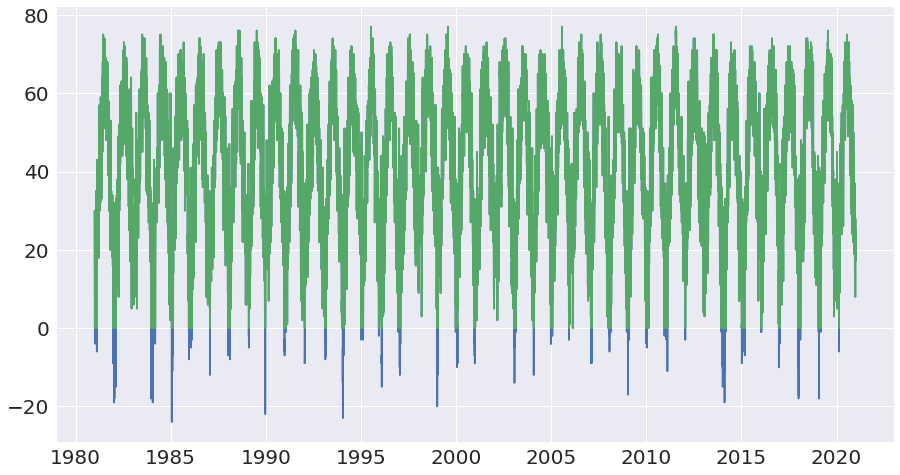

In [55]:
# Select the rows to modify and then modify them.
w_copy.loc[w_copy.mint < 0, 'mint'] = 0

plt.plot(w.mint)
plt.plot(w_copy.mint) 

plt.show()

# Getting comfortable with Matplotlib

## Plot a line

**Task:** Plot of all the max temperature data in one plot.

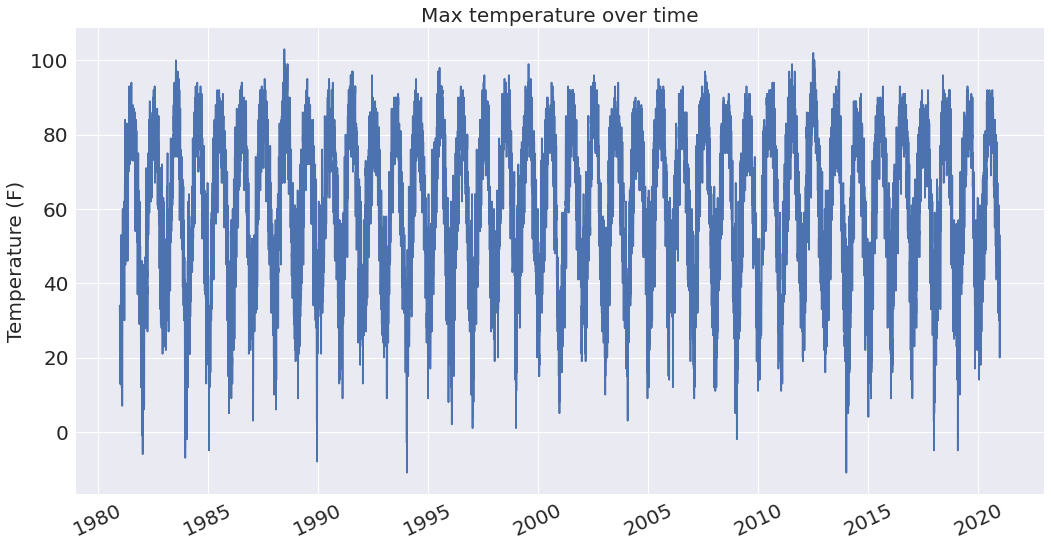

In [56]:
# Matplotlib combined with Pandas makes plotting really easy!
# Note: Matplotlib was able to determine the correct x-axis based on the DataFrame's index (in this case, date)
plt.plot(w.maxt)

# We can improve the plot by adding labels, title, and tick rotation (the date strings are long)
plt.ylabel('Temperature (F)')
plt.title('Max temperature over time')
plt.xticks(rotation=25)

# A "tight layout" just reduces the amount of white space in the figure. A bit noisier but also larger plots.
plt.tight_layout()
plt.show()

## Plotting multiple lines

**Task:** Plot both the 2019 minimum and maximum temperatures as separate lines on the same plot

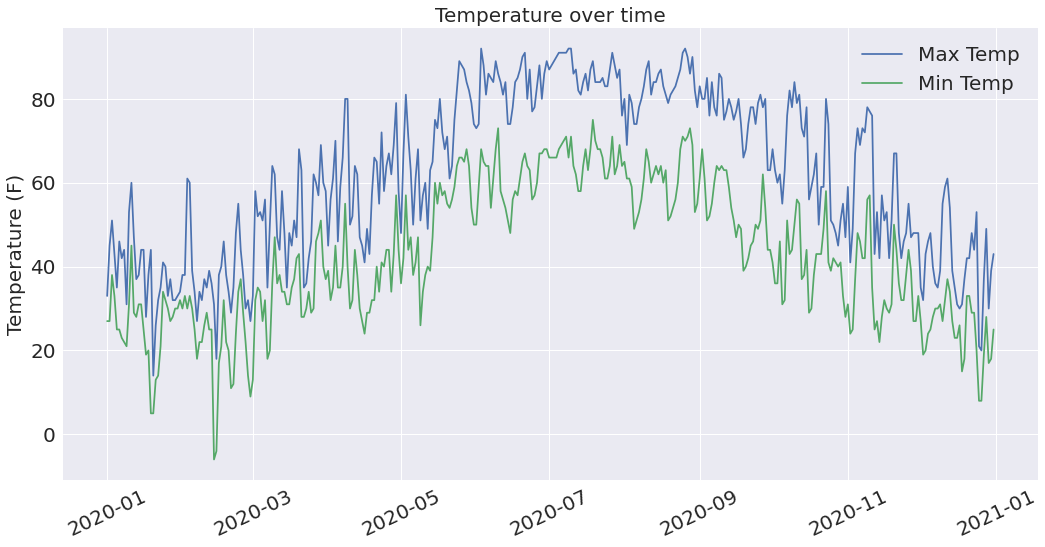

In [57]:
# We store the slice into 'w' as w20 for convenience (we will use it over and over again)
w20 = w['2020-01-01':'2020-12-31'];

# Calling `plot` multiple times add additional lines to the same figure
plt.plot(w20.maxt)
plt.plot(w20.mint)

# Add a legend to distinguish between the two curves
plt.legend(['Max Temp', 'Min Temp'])
plt.ylabel('Temperature (F)')
plt.title('Temperature over time')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

## Plotting two plots on one figure

**Task:** Plot both the 2019 minimum and maximum temperatures as separate lines on one plot and 2019 precipitation on the other. Make the two plots stack vertically and share the same time axis.

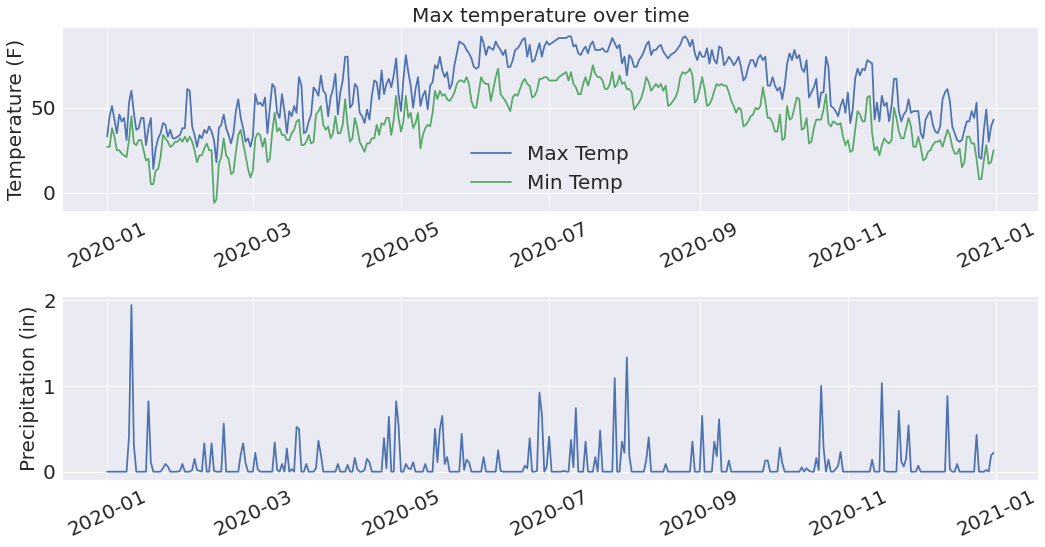

In [58]:
### Put two plots on one figure

# The `subplot` command allows us to slice up one image and draw multiple independent figures into each slice
# In this case, we are slicing the image into 2 rows and 1 column. We select the first slice.
ax = plt.subplot(2, 1, 1)
plt.plot(w20.maxt)
plt.plot(w20.mint)

plt.legend(['Max Temp', 'Min Temp'])
plt.ylabel('Temperature (F)')
plt.title('Max temperature over time')
plt.xticks(rotation=25)

# Now we select the second slice. Notice we share the x-axis. This is so when you interact with the either plot
# the other plot is automatically adjusted to the same scale.
plt.subplot(2, 1, 2, sharex=ax)
plt.plot(w20.pcpn)

plt.ylabel('Precipitation (in)')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

## Grouping and reducing

In Pandas, you can group a DataFrame by a field or condition and then apply an operation to each group. The output is a new DataFrame indexed by the "group by" value and with values equal to the return of each operation.

**Task:** Find the maximum precipitation for each year

In [59]:
byYear = w.groupby(w.index.year)

byYear.pcpn.max()

date
1981    3.74
1982    2.15
1983    3.08
1984    2.13
1985    2.15
1986    2.72
1987    3.44
1988    1.96
1989    2.29
1990    3.79
1991    2.33
1992    2.29
1993    2.21
1994    3.69
1995    2.27
1996    1.97
1997    2.35
1998    1.82
1999    3.18
2000    4.19
2001    2.29
2002    2.05
2003    2.68
2004    4.49
2005    1.55
2006    1.97
2007    2.41
2008    1.94
2009    2.70
2010    3.07
2011    2.70
2012    3.26
2013    2.89
2014    2.18
2015    2.35
2016    2.46
2017    1.86
2018    2.61
2019    1.60
2020    1.94
Name: pcpn, dtype: float64

## Merge two group reductions

**Task:** Find the maximum and minimum temperature for each year

In [60]:
pd.concat([byYear.maxt.max(), byYear.mint.min()], axis='columns')

,maxt,mint
date,,
1981,94,-9
1982,93,-19
1983,100,-18
1984,94,-19
1985,92,-24
1986,94,-5
1987,95,-12
1988,103,-8
1989,95,-22


## Plot group by reduction

**Task:** Make an error bar plot of temperature over a year

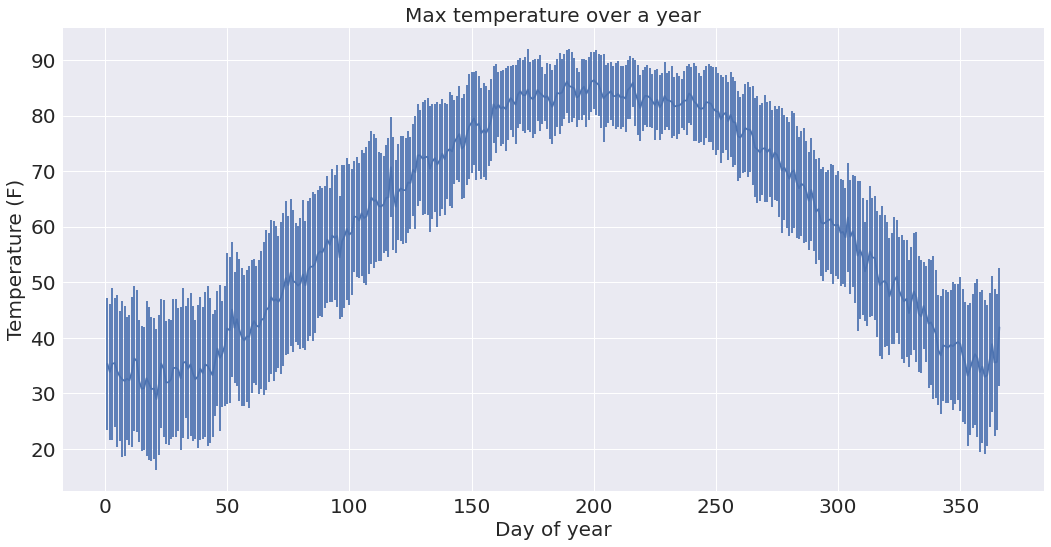

In [61]:
# Day of year: Jan 1 -> 0, Jan 2 -> 1, Jan 3 -> 2, ... without regard the actual year
byDay = w.groupby(w.index.dayofyear)

# You can select a column out of the "GroupBy" before processing them
# You can use the resulting DataFrame just like before, e.g., plotting.
plt.errorbar(byDay.groups.keys(), byDay.maxt.mean(), byDay.maxt.std())

plt.xlabel('Day of year')
plt.ylabel('Temperature (F)')
plt.title('Max temperature over a year')

plt.tight_layout()
plt.show()

## Combining DataFrame and GroupBy data on one plot

**Task**: Display the average minimum and maximum temperatures over the 2019 data.

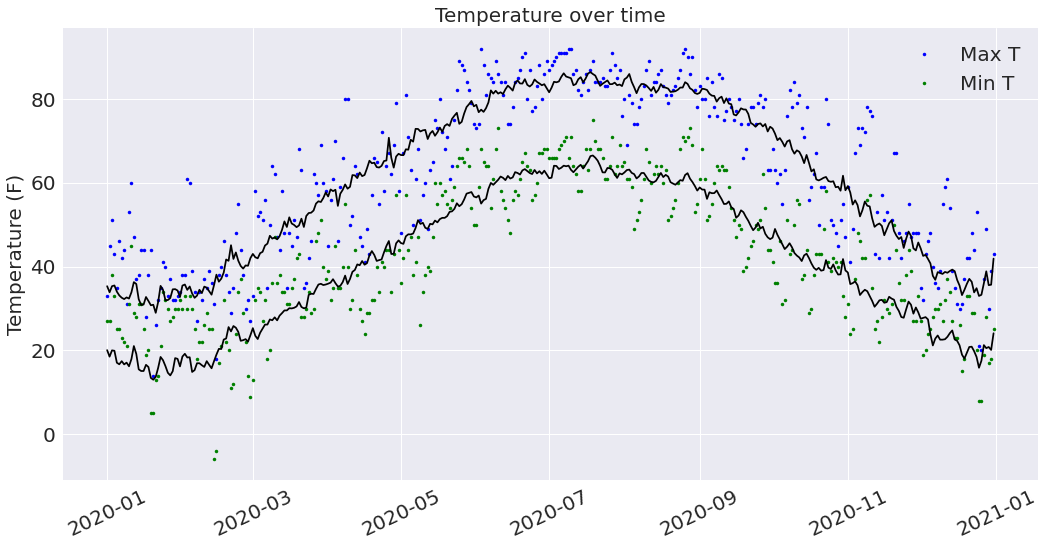

In [62]:
plt.plot(w20.maxt, 'b.')
plt.plot(w20.mint, 'g.')
plt.plot(w20.index, byDay.maxt.mean(), 'k')
plt.plot(w20.index, byDay.mint.mean(), 'k')

plt.legend(['Max T', 'Min T'])
plt.ylabel('Temperature (F)')
plt.title('Temperature over time')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

# Growing Degree Units
## Computing GDUs for an ACRE field using public ACIS/PRISM gridded weather data

Let's start by simply plotting this year's current GDU curve.

We didn't fetch 2021 weather data in our earlier request to ACIS. So, here we use the same code with new date ranges to download up to 2021-07-01 (today's date as of this writing). Just like before, we finish up by converting the fetched data into a Pandas DataFrame.

### Planting records
Let's also note the planting records for this field.

- The field was (hypothetically) planted with Dekalb DKC64-35RIB.
- The manufacture claims 2954 to black layer ([Dekalb DKC64-35RIB Datasheet](https://cdn.websites.hibu.com/f091a3ebdd4e480a8da11c597fdbfb00/files/uploaded/DKC64-35RIB.pdf)).
- The field was (hypothetically) planted on April 4th, 2021.

In [63]:
plant_date = "2021-04-25"
gdu_to_black = 2594

now_date = "2021-07-01"

# We will use the "standard" corn 86/50 max/base values
t_max = 86
t_base = 50

# Fetch data from ACIS, let's call "w_field" so we all have the same name  
w_field = requests.post('http://data.rcc-acis.org/GridData', json={
    "loc": f"{lon}, {lat}",
    "sdate": plant_date,
    "edate": now_date,
    "grid": "21",   # "21" is PRISM
    "elems": [
        { "name":"maxt", "interval":"dly", "units":"degreeF" },
        { "name":"mint", "interval":"dly", "units":"degreeF" },
        { "name":"pcpn", "interval":"dly", "units":"inch" }
    ]
}).json()

# Create a Pandas DataFrame to hold the min and max temperature and precipitation data
w_field = pd.DataFrame(w_field['data'], columns=['date', 'maxt', 'mint', 'pcpn'])

# Convert the date "string" into a date object (so Pandas understands it as a date)
w_field['date'] = pd.to_datetime(w_field['date'])

# Then make it the primary index so we can easily slice the data up by time
w_field.set_index('date', inplace=True)

w_field.head()

,maxt,mint,pcpn
date,,,
2021-04-25,58,42,0.04
2021-04-26,58,39,0.00
2021-04-27,79,47,0.00
2021-04-28,87,66,0.00
2021-04-29,74,55,1.56


## GDU accumulation from planting date

**Recall**: 

$GDU = \frac{T_\textrm{high} + T_\textrm{low}}{2}$

When $T_\textrm{high} = T_\textrm{max}$ when $T_\textrm{high} > T_\textrm{max}$. All negative GDU is replaced with zero.

**Task:** Compute the current GDU accumulation for the field

In [64]:
# "Modify" the temp data for corn's upper threshold max
w_field.loc[w_field.maxt > t_max, 'maxt'] = t_max

# Save the daily GDU totals back to the DataFrame as a new column
w_field['gdu'] = (w_field.maxt + w_field.mint) / 2 - t_base

# Negative GDUs are assumed to be zero ... that is a colder day doesn't reduce the growth
w_field.loc[w_field.gdu < 0, 'gdu'] = 0 

# Determine the total GDUs from the plant date
field_gdu = w_field[plant_date:].gdu.sum()

field_gdu

1137.5

## Estimating the current growth stage

**Recall:**

$V = 42 \frac{GDU}{GDU_\textrm{black}} - 2.23$

$R = 10.3 \frac{GDU}{GDU_\textrm{black}} - 4.37$

**Task:** Using the given growth stage formulas, estimate the current stage.

In [65]:
# Note: these formals are fit from data found in the literature
V = 42 * (field_gdu / gdu_to_black) - 2.23
R = 10.3 * (field_gdu / gdu_to_black) - 4.37

# Note: A "negative" R indicates that the plant is not yet in the reproductive stage.
print(f"V: {V}, R: {R}")

V: 16.18750192752506, R: 0.14667309175019305


## Computing historical GDU curves

**Task:** Compute the year long GDU curve for each year and plot them all on the same figure.

_Note: A "GDU curve" is the cumulative sum of the GDU from some starting point. Usually the first of the year, unless you are studying a particular field, then it would be from planting date. That is, the GDU's accumulated by the corn itself._

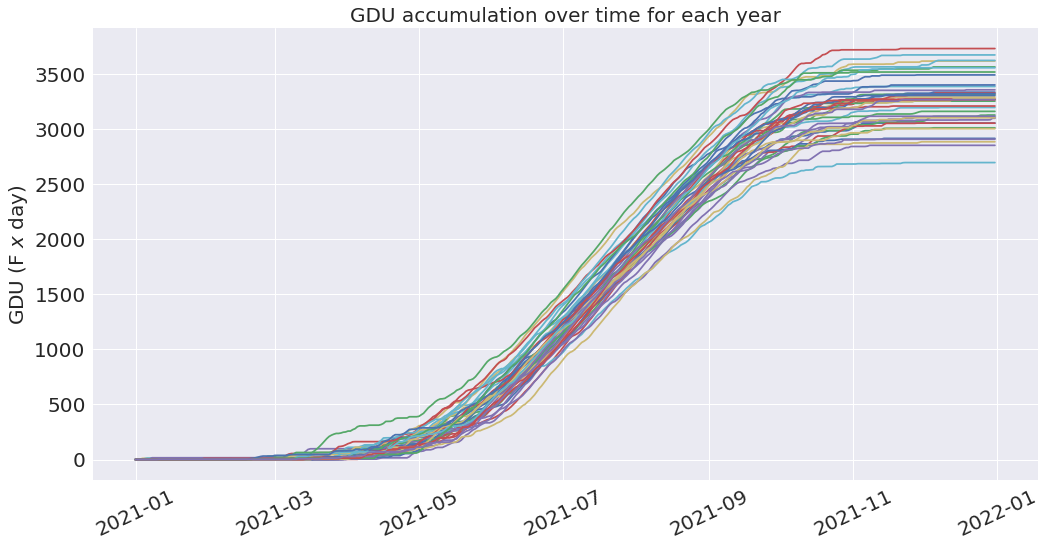

In [66]:
# Create a helper date range for plotting "day of year" data. Use this as the x-axis data for any plot where the 
# y data is based on "day of year" to get a real date on the x-axis
y21 = pd.date_range('2021-01-01', periods=365)

# Save a copy of the weather data as "w_corn" because we are going to "modify" the temperature data
w_corn = w.copy();

# "Modify" the temp curve for corn max
w_corn.loc[w_corn.maxt > t_max, 'maxt'] = t_max

w_corn['gdu'] = (w_corn.maxt + w_corn.mint) / 2 - t_base
w_corn.loc[w_corn.gdu < 0, 'gdu'] = 0

# The 'cumsum' function is "cumulative sum". That means the output of a 'cumsum' operation is a vector the
# same length as the input vector. However, the output vector is like:
#   index 0: equal to original value at index 0
#   index 1: equal to original value at index 0 + original value at index 1
#   index 2: equal to output at index 1 + original value at index 2
#   index 3: equal to output at index 2 + original value at index 3
#   index N: equal to output at index N-1 + original value at index N
#
# In this case, we are 'cumsum'ing down the GDUs, grouped by year. So we will end up with a DataFrame indexed by
# the same date column.
gdu_curve_by_year = w_corn.gdu.groupby(w_corn.index.year).cumsum()

# Now, re-group the accumlation by year again and loop over each, plotting a line each time (year)
for year, gdu_curve  in gdu_curve_by_year.groupby(gdu_curve_by_year.index.year):
    # We only plot from 0:365 to avoid an x and y mismatch
    plt.plot(y21, gdu_curve[0:365], label=year)

plt.ylabel('GDU (F $x$ day)')
plt.title('GDU accumulation over time for each year')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()

## Plot the min, max, and average curves

**Task:** Plot the GDU curve historical extremes, the average GDU curve, the current year GDU curve, and a projection of the rest year on one plot. Use a graphical techniques to estimate date of next growth stage.

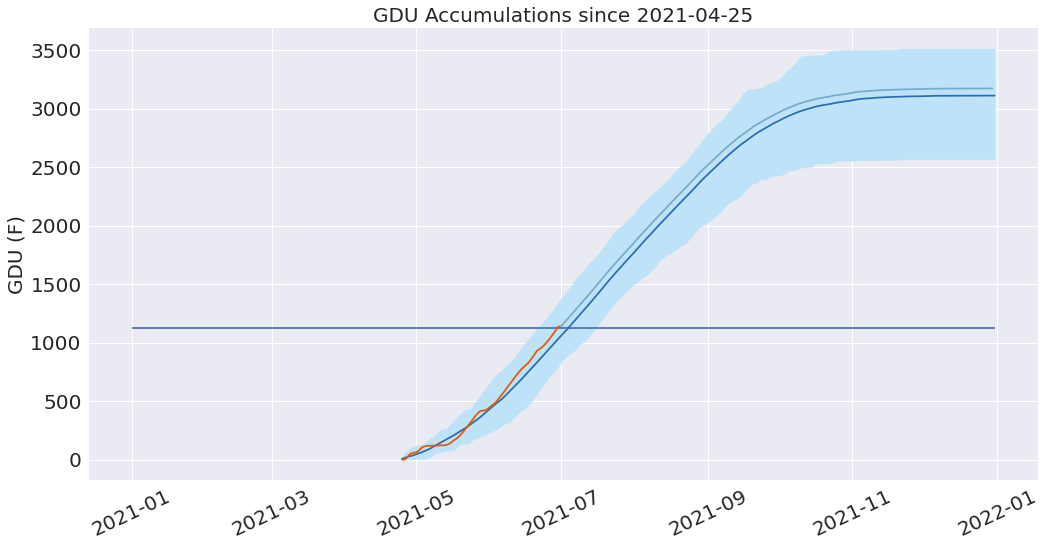

In [67]:
#######
### Find the historical extremes
#######

# We will need to now the plant date's day of year
plant_dayofyear = pd.Period(plant_date).dayofyear

# Slice the historical dataset down to days after plant date's calendar day
gdu = w_corn[w_corn.index.dayofyear >= plant_dayofyear]['gdu']

# Compute the curves from that new starting date
gdu_curve = gdu.groupby(gdu.index.year).cumsum()

# Find the min, max, and avg accumulations for each day over the years
min_gdu = gdu_curve.groupby(gdu_curve.index.dayofyear).min()[0:-1]
max_gdu = gdu_curve.groupby(gdu_curve.index.dayofyear).max()[0:-1]
avg_gdu = gdu_curve.groupby(gdu_curve.index.dayofyear).mean()[0:-1]

# Helper date range computations
y_field = pd.date_range(start=plant_date, periods=365-plant_dayofyear+1)

# Plot the historical extremes
plt.fill_between(y_field, min_gdu, max_gdu, color='#bee3f8')

# Plot the historical average
plt.plot(y_field, avg_gdu, color='#2b6cb0')

#######
### Find this year's GDU curve
#######

# Compute this year's GDU curve from plant date
cur_gdu_curve = w_field[plant_date:].gdu.cumsum()

# Plot the current years GDU curve
plt.plot(pd.date_range(start=plant_date, end=now_date), cur_gdu_curve, color='#eb5600')

#######
### Projection this year's GDU curve out using the historical average
#######

# Compute the projection
gdu_proj =  avg_gdu[len(cur_gdu_curve):] - avg_gdu[plant_dayofyear + len(cur_gdu_curve)] + cur_gdu_curve[-1]

# Helper date range computations
y_field_future = pd.date_range(start=now_date, periods=365-plant_dayofyear-len(cur_gdu_curve)+1)

# Plot the projection of the current years GDU curve
plt.plot(y_field_future, gdu_proj, color='#76abcd')

#######
### Plot stage v16
#######
plt.hlines((16 + 2.23) * gdu_to_black / 42, y21[0], y21[-1])

plt.ylabel('GDU (F)')
plt.title(f'GDU Accumulations since {plant_date}')
plt.xticks(rotation=25)

plt.tight_layout()
plt.show()